# AC__TC__2B

Import libraries:

In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm

from scipy import stats  # will use scipy.stats.mode as the reducer
import matplotlib.colors as mcolors
from matplotlib.patches import Patch


### ESA MAAP (STAC) Catalog API 
Point to the catalogue endpoint

In [2]:
catalog_url = 'https://catalog.maap.eo.esa.int/catalogue/'
catalog = Client.open(catalog_url)

In [3]:
EC_COLLECTION = ['EarthCAREL2Validated_MAAP']

**Filter** - allows you to search based on different metadata parameters. To understand which queryables exist you can visit: [Queryables](https://catalog.maap.eo.esa.int/catalogue/collections/EarthCAREL1Validated_MAAP/queryables). 
Examples include: 
* productType
* frame 
* processingLevel
* instrument
* orbitNumber 
... 

**Datetime** represents the temporal coverage of the data. None can be used for both start and end to indicated unbounded queries.  

**bbox** is defined by the bottom left corner (longmin latmin) and the top right corner coordinates (longmax latmax) 


In [4]:
search = catalog.search(
    collections=EC_COLLECTION, 
    filter="productType = 'AC__TC__2B' and (frame = 'E' or frame = 'A')", # Filter by product type
    bbox = [100, -15, 160, 30],
    #datetime = ['2025-06-06T00:00:00Z', None] 
    method = 'GET', # This is necessary 
    max_items=1e3 #5  # Adjust as needed, given the large aoutn of products it is recommended to set a limit
)

items = list(search.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{search.matched()} items found that matched the query.")

Accessing 308 items (limited by max_items).
308 items found that matched the query.


This can become a function later on:

In [5]:
# Using Pandas dataframes for ease of use. This is not mandatory, but just a nice way to get an overview of the products you found through the search. Please note that pandas dataframes run into issues if we try to pass to many products. Use max_items! :) 
data = search.item_collection_as_dict()

df = pd.json_normalize(data, record_path=['features'])[
    [
        "id",
        "properties.product:type",                
        "properties.updated",                     
        "assets.product.href",
        #"assets.thumbnail.href",
        "assets.quicklook.href",
        "assets.enclosure_1.href",
        "assets.enclosure_2.href",
    ]
]

# Renaming the assets for 
df.rename(columns={
    'properties.product:type': 'product_type',
    'properties.updated': 'last_modified',
    'assets.product.href': 'Zipped Product',
    #'assets.thumbnail.href': 'thumbnail_url',
    'assets.quicklook.href': 'quicklook_url',
    'assets.enclosure_1.href': 'h5_url',
    'assets.enclosure_2.href': 'HDR_url',
}, inplace=True)

df.sort_values(by='id', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)


In [6]:
df

,id,product_type,last_modified,Zipped Product,quicklook_url,h5_url,HDR_url
0,ECA_EXAD_AC__TC__2B_20250612T065354Z_20250612T...,AC__TC__2B,2025-09-11T20:04:53Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
1,ECA_EXAD_AC__TC__2B_20250612T152257Z_20250612T...,AC__TC__2B,2025-09-11T20:05:09Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
2,ECA_EXAD_AC__TC__2B_20250612T165530Z_20250612T...,AC__TC__2B,2025-09-11T20:05:11Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
3,ECA_EXAD_AC__TC__2B_20250612T182803Z_20250612T...,AC__TC__2B,2025-09-11T20:05:15Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
4,ECA_EXAD_AC__TC__2B_20250613T042931Z_20250613T...,AC__TC__2B,2025-09-11T20:05:33Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
...,...,...,...,...,...,...,...
303,ECA_EXBA_AC__TC__2B_20250922T151109Z_20250922T...,AC__TC__2B,2025-09-23T09:10:57Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
304,ECA_EXBA_AC__TC__2B_20250922T164342Z_20250922T...,AC__TC__2B,2025-09-25T15:12:30Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
305,ECA_EXBA_AC__TC__2B_20250922T181614Z_20250922T...,AC__TC__2B,2025-09-25T15:12:32Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
306,ECA_EXBA_AC__TC__2B_20250923T041740Z_20250923T...,AC__TC__2B,2025-09-25T15:12:52Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,NaN,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...


## Quicklook of the data

In [7]:
# Choose the file you want to view/stream/download 

fileno = 11 #2 # Adjust this as desired 
ql_url = df.loc[fileno, "quicklook_url"]
# Note: thumbnail is a lower resolution version
display(Image(url= ql_url))
#https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/AC__TC__2B/AD/2025/06/14/ECA_EXAD_AC__TC__2B_20250614T064245Z_20250614T224408Z_05933E/public/ECA_EXAD_AC__TC__2B_20250614T064245Z_20250614T224408Z_05933E.BID_0.jpeg

### Token
You can generate the token [here](https://portal.maap.eo.esa.int/ini/services/auth/token/index.php). Currently this is only valid for 10 h! 


In [8]:
with open("token.txt","rt") as f:
    token = f.read().strip().replace("\n","")

The **AC__TC__2B**'s data is contained in ScienceData: 

In [9]:
ds_url = df.loc[fileno, "h5_url"]
print(ds_url)
#ds_url = 'https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/BBR_NOM_1B/BA/2025/06/06/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B.h5'


https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/AC__TC__2B/AD/2025/06/14/ECA_EXAD_AC__TC__2B_20250614T064245Z_20250614T224408Z_05933E/ECA_EXAD_AC__TC__2B_20250614T064245Z_20250614T224408Z_05933E/ECA_EXAD_AC__TC__2B_20250614T064245Z_20250614T224408Z_05933E.h5


In [10]:
fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
with fs.open(ds_url, "rb") as f:
    ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData").compute()
ds
# Do somethign with ds 

<xarray.Dataset> Size: 23MB
Dimensions:                                             (along_track: 5063,
                                                         JSG_height: 242)
Dimensions without coordinates: along_track, JSG_height
Data variables: (12/21)
    time                                                (along_track) datetime64[ns] 41kB ...
    latitude                                            (along_track) float64 41kB ...
    longitude                                           (along_track) float64 41kB ...
    geoid_offset                                        (along_track) float64 41kB ...
    elevation                                           (along_track) float32 20kB ...
    height                                              (along_track, JSG_height) float32 5MB ...
    ...                                                  ...
    CPR_ATLID_status                                    (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_low_resolution_status                     (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_medium_resolution_status                  (along_track, JSG_height) int8 1MB ...
    quality_status                                      (along_track, JSG_height) int8 1MB ...
    quality_low_resolution_status                       (along_track, JSG_height) int8 1MB ...
    quality_medium_resolution_status                    (along_track, JSG_height) int8 1MB ...

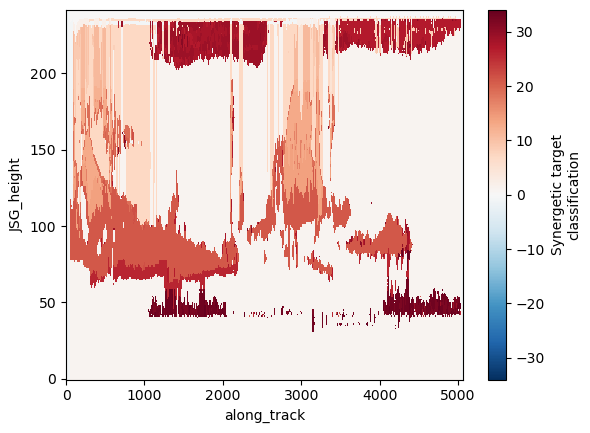

In [11]:
ds['synergetic_target_classification'].plot(x='along_track')
plt.show()

Assign coordinates:

In [12]:
ds_coo = ds.assign_coords(along_track=ds['time'], JSG_height=ds['height'].isel(along_track=0))
ds_coo

<xarray.Dataset> Size: 24MB
Dimensions:                                             (along_track: 5063,
                                                         JSG_height: 242)
Coordinates:
  * along_track                                         (along_track) datetime64[ns] 41kB ...
  * JSG_height                                          (JSG_height) float32 968B ...
Data variables: (12/21)
    time                                                (along_track) datetime64[ns] 41kB ...
    latitude                                            (along_track) float64 41kB ...
    longitude                                           (along_track) float64 41kB ...
    geoid_offset                                        (along_track) float64 41kB ...
    elevation                                           (along_track) float32 20kB ...
    height                                              (along_track, JSG_height) float32 5MB ...
    ...                                                  ...
    CPR_ATLID_status                                    (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_low_resolution_status                     (along_track, JSG_height) int8 1MB ...
    CPR_ATLID_medium_resolution_status                  (along_track, JSG_height) int8 1MB ...
    quality_status                                      (along_track, JSG_height) int8 1MB ...
    quality_low_resolution_status                       (along_track, JSG_height) int8 1MB ...
    quality_medium_resolution_status                    (along_track, JSG_height) int8 1MB ...

Reduce the vertical resolution:

In [13]:
binned = ds_coo['synergetic_target_classification'].groupby_bins('JSG_height', bins=[0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000])
ds_coarse = binned.reduce(lambda arr, axis: stats.mode(arr, axis=axis, keepdims=False).mode)

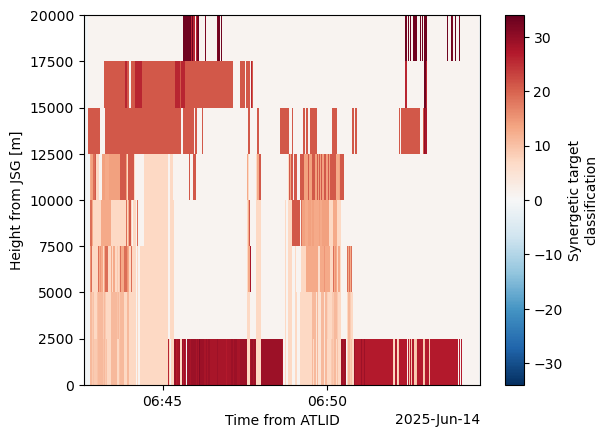

In [14]:
ds_coarse.plot(x='along_track')

In [15]:
ds_coarse

<xarray.DataArray 'synergetic_target_classification' (along_track: 5063,
                                                      JSG_height_bins: 8)> Size: 41kB
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], shape=(5063, 8), dtype=int8)
Coordinates:
  * along_track      (along_track) datetime64[ns] 41kB 2025-06-14T06:42:36.35...
  * JSG_height_bins  (JSG_height_bins) interval[int64, right] 128B (0, 2500] ...
Attributes:
    long_name:    Synergetic target classification
    plot_range:   [-1 33]
    plot_colors:  #c5c9c7\n #a2653e\n #ffffff\n #ff474c\n #0504aa\n #009337\n...
    definition:   -1: unknown\n 0: ground\n 1: clear\n 2: possible rain (clut...

Let's get the correct color scale:

In [16]:
# Synergetic class range and colors
plot_range = range(-1, 35)  # inclusive -1..33
plot_colors = [
    "#c5c9c7", "#a2653e", "#ffffff", "#ff474c", "#0504aa", "#009337",
    "#840000", "#042e60", "#d8dcd6", "#ffff84", "#f5bf03", "#f97306",
    "#ff000d", "#5539cc", "#2976bb", "#0d75f8", "#014182", "#017b92",
    "#06b48b", "#aaff32", "#6dedfd", "#01f9c6", "#7bc8f6", "#d7fffe",
    "#a2cffe", "#04d9ff", "#7a9703", "#b2996e", "#ffbacd", "#d99b82",
    "#947e94", "#856798", "#ac86a8", "#59656d", "#76424e", "#363737"
]

labels = [
    "-1: unknown"," 0: ground"," 1: clear"," 2: possible rain (clutter)"," 3: possible snow (clutter)",
    " 4: possible cloud (clutter)"," 5: heavy rain"," 6: heavy mixed-phase precip",
    " 7: no rain/ice (possible liquid)"," 8: liquid cloud"," 9: drizzling liquid cloud",
    "10: warm rain","11: cold rain","12: melting snow","13: snow (possible liquid)",
    "14: snow (no liquid)","15: rimed snow (possible liquid)",
    "16: rimed snow + supercooled liquid","17: snow + supercooled liquid",
    "18: supercooled liquid","19: ice cloud (possible liquid)",
    "20: ice + supercooled liquid","21: ice cloud (no liquid)",
    "22: stratospheric ice","23: STS (PSC Type I)","24: NAT (PSC Type II)","25: insects",
    "26: dust","27: sea salt","28: continental pollution","29: smoke","30: dusty smoke",
    "31: dusty mix","32: stratospheric ash","33: stratospheric sulfate","34: stratospheric smoke"
]

# Build discrete colormap
cmap = mcolors.ListedColormap(plot_colors)
bounds = list(plot_range) + [34]   # bin edges
norm = mcolors.BoundaryNorm(bounds, cmap.N)

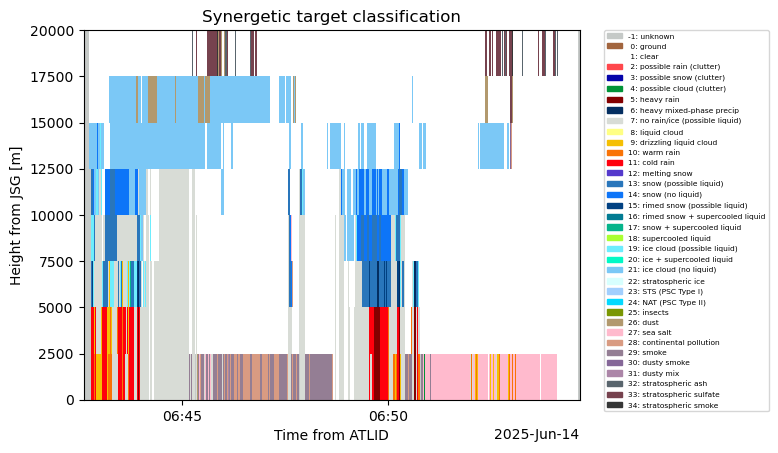

In [17]:
# Example: suppose your classification variable is called "target_class"
ds_coarse.plot(
    x="along_track",
    cmap=cmap,
    norm=norm,
    add_colorbar=False
)

# Build legend patches
patches = [Patch(color=plot_colors[i], label=labels[i]) for i in range(len(labels))]

# Add legend outside plot
plt.legend(
    handles=patches,
    bbox_to_anchor=(1.05, 1), loc="upper left",
    borderaxespad=0., fontsize=5.4, ncol=1
)
plt.title("Synergetic target classification")
plt.show()

Assign a variable for each layer (8) OR create boolean variables with questions: sea salt? stratosphere sulfate?

## Let's loop!!

In [18]:
len(df)

308

In [19]:
nooffiles = len(df) #silly name
# nooffiles = 10 #testing

In [20]:
frames = []
for fileno in tqdm(range(nooffiles)):
    # print(fileno)
    
    ds_url = df.loc[fileno, "h5_url"]
    
    fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
    with fs.open(ds_url, "rb") as f:
        
        # Open the data
        ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData").compute()
        
        # Get the variables
        selection = ds[['latitude', 'longitude', 'synergetic_target_classification']]
        
        # Set unique coordinate to along track dimension
        # selection = selection.assign_coords(along_track=ds['time'])
        selection = selection.assign_coords(along_track=ds['time'], JSG_height=ds['height'].isel(along_track=0))
        selection = selection.rename({"along_track":"time"})
        
        binned = selection['synergetic_target_classification'].groupby_bins('JSG_height', bins=[0, 2500, 5000, 7500, 10000, 12500, 15000, 17500, 20000])
        coarse = binned.reduce(lambda arr, axis: stats.mode(arr, axis=axis, keepdims=False).mode)
        
        # Turn bins into variables
        binned_ds = coarse.to_dataset(dim="JSG_height_bins")

        # Clean variable names (optional: make them short and safe)
        binned_ds = binned_ds.rename(
            {bin_label: f"stc_{(i+1)*2500}" for i, bin_label in enumerate(binned_ds.data_vars)}
        )
        
        # Append to the original Dataset
        final = selection[['latitude', 'longitude']].merge(binned_ds)
        
        frames.append(final)


00%|██████████| 308/308 [04:19<00:00,  1.18it/s]

In [21]:
radar = xr.concat(frames, dim='time')
radar_1s = radar.resample(time='1s').mean().dropna(dim='time', how='all')
radar_1s

<xarray.Dataset> Size: 20MB
Dimensions:    (time: 222822)
Coordinates:
  * time       (time) datetime64[ns] 2MB 2025-06-12T06:53:45 ... 2025-09-23T0...
Data variables:
    latitude   (time) float64 2MB 23.33 23.28 23.21 ... -23.27 -23.34 -23.38
    longitude  (time) float64 2MB 108.8 108.8 108.8 108.8 ... 115.5 115.5 115.5
    stc_2500   (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 12.43 -1.0 -1.0 -1.0
    stc_5000   (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 0.4286 -1.0 -1.0 -1.0
    stc_7500   (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 0.4286 -1.0 -1.0 -1.0
    stc_10000  (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 0.4286 -1.0 -1.0 -1.0
    stc_12500  (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 0.4286 -1.0 -1.0 -1.0
    stc_15000  (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 0.4286 -1.0 -1.0 -1.0
    stc_17500  (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 0.4286 -1.0 -1.0 -1.0
    stc_20000  (time) float64 2MB -1.0 -1.0 -1.0 -1.0 ... 0.4286 -1.0 -1.0 -1.0

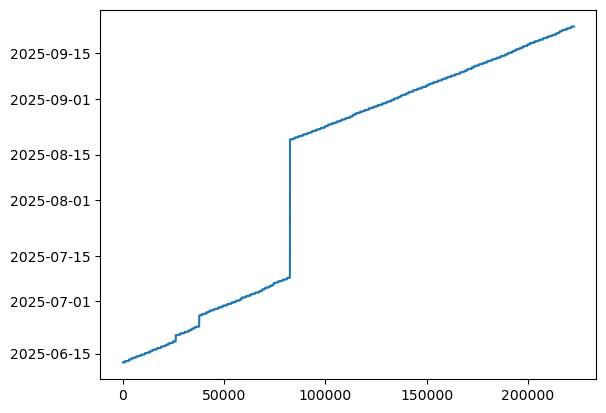

In [22]:
plt.plot(radar_1s.indexes['time'])

In [23]:
radar_1s.time

<xarray.DataArray 'time' (time: 222822)> Size: 2MB
array(['2025-06-12T06:53:45.000000000', '2025-06-12T06:53:46.000000000',
       '2025-06-12T06:53:47.000000000', ..., '2025-09-23T06:02:04.000000000',
       '2025-09-23T06:02:05.000000000', '2025-09-23T06:02:06.000000000'],
      shape=(222822,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2MB 2025-06-12T06:53:45 ... 2025-09-23T06:...
Attributes:
    long_name:   Time from ATLID
    definition:  Time

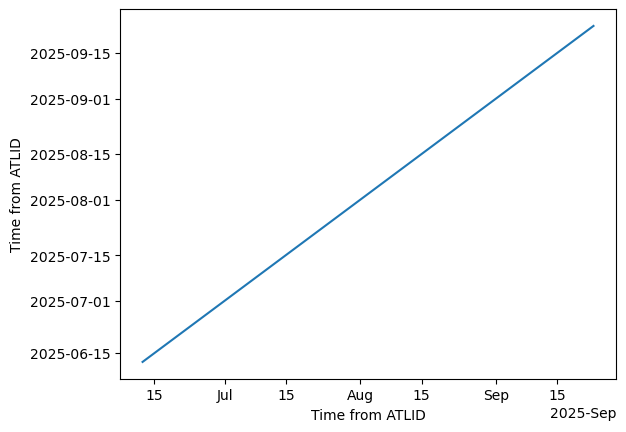

In [24]:
radar_1s.time.plot()


## Save a netCDF file:

In [25]:
radar_1s.to_netcdf('AC__TC__2B_1s_WP.nc')

In [26]:
%cp "AC__TC__2B_1s_WP.nc" "/home/jovyan/my-private-bucket/."

In [27]:
%ls -l /home/jovyan/

total 40
drwxrwsr-x 3 jovyan users  4096 Sep 23 13:48 conda_envs/
lrwxrwxrwx 1 jovyan users    51 Sep 23 13:30 documentation -> shared-buckets/6173c8db-3049-4300-ac3e-901ee10abf16/
drwxrwsr-x 4 jovyan users  4096 Sep 28 21:12 earthcare_aerosol_cloud_interactions/
drwxrws--- 2 root   users 16384 Sep 23 10:07 lost+found/
lrwxrwxrwx 1 root   users    72 Sep 23 10:07 my-private-bucket -> /data/experiment/my-private-storage/c203d5c4-704c-4a4a-8b35-1d123a32a6ae/
lrwxrwxrwx 1 root   users    71 Sep 23 10:07 my-public-bucket -> /data/experiment/my-public-storage/c203d5c4-704c-4a4a-8b35-1d123a32a6ae/
drwxrwsr-x 2 root   users  4096 Sep 23 10:07 my_storage/
lrwxrwxrwx 1 jovyan users    51 Sep 23 14:32 paula-public-bucket -> shared-buckets/e87a5ac1-705f-410b-8253-2b53c6d8eaab/
drwxrwsrwx 2 root   users  4096 Sep 28 19:44 shared/
lrwxrwxrwx 1 root   users    31 Sep 23 10:07 shared-buckets -> /data/experiment/public-storage/


In [28]:
%pwd

'/home/jovyan/earthcare_aerosol_cloud_interactions'